# Caso Practico: Support Vector Machine (SVM).

### DataSet: Deteccion de URLs Maliciosas:

The Web has long become a major platform for online criminal activities. URLs are used as the main vehicle in this domain. To counter this issues security community focused its efforts on developing techniques for mostly blacklisting of malicious URLs.

While successful in protecting users from known malicious domains, this approach only solves part of the problem. The new malicious URLs that sprang up all over the web in masses commonly get a head start in this race. Besides that, Alexa ranked, trusted websites may convey compromised fraudulent URLs called defacement URL.

We explore a lightweight approach to detection and categorization of the malicious URLs according to their attack type and show that lexical analysis is effective and efficient for proactive detection of these URLs. We also study the effect of the obfuscation techniques on malicious URLs to figure out the type of obfuscation technique targeted at specific type of malicious URL. We study mainly five different types of URLs:

Benign URLs: Over 35,300 benign URLs were collected from Alexa top websites. The domains have been passed through a Heritrix web crawler to extract the URLs. Around half a million unique URLs are crawled initially and then passed to remove duplicate and domain only URLs. Later the extracted URLs have been checked through Virustotal to filter the benign URLs.

Spam URLs: Around 12,000 spam URLs were collected from the publicly available WEBSPAM-UK2007 dataset.

Phishing URLs: Around 10,000 phishing URLs were taken from OpenPhish which is a repository of active phishing sites.

Malware URLs: More than 11,500 URLs related to malware websites were obtained from DNS-BH which is a project that maintain list of malware sites.

Defacement URLs: More than 45,450 URLs belong to Defacement URL category. They are Alexa ranked trusted websites hosting fraudulent or hidden URL that contains both malicious web pages.

Obfuscation is used as a common method for masking malicious URLs. An attacker intending to evade static analysis on lexical URL features use obfuscation techniques so that malicious URLs become statistically like the benign ones. The obfuscation techniques on URLs is analyzed for the intent of malicious activity in this research. We analyzed mainly Spam, Phishing and Malware URLs to see what kind of obfuscation techniques applied on the URLs.

## Import

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

## Funciones Auxiliares

In [3]:
# Construccion de una funcion que realice el particionado completo
def train_val_test_split(df, rsate = 42, shuffle = True, stratify = None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size = 0.4, random_state = rsate, shuffle = shuffle, stratify = strat  
    )
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size = 0.5, random_state = rsate, shuffle = shuffle, stratify = strat
    )
    return (train_set, val_set, test_set)

In [4]:
# Representaciom grafica del limite de decision.
def plot_svm_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 -b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0- b/w[1]
    
    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svm = svm_clf.support_vectors_
    plt.scatter(svm[:, 0], svm[:, 1], s = 180, facecolors = '#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth = 2)
    plt.plot(x0, gutter_up, "k--", linewidth = 2)
    plt.plot(x0, gutter_down, "k--", linewidth = 2)
    

## 1.- Lectura del DataSet.

In [5]:
df = pd.read_csv("../datasetsSVM/Malware.csv")

## 2.- Visualizacion del DataSet

In [6]:
df.head(10)

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
0,0,2,12,5.5,8,4.083334,2,15,7,0,...,-1,-1,-1,0.676804,0.860529,-1.000000,-1.000000,-1.00000,-1.000000,benign
1,0,3,12,5.0,10,3.583333,3,12,8,2,...,1,0,-1,0.715629,0.776796,0.693127,0.738315,1.00000,-1.000000,benign
2,2,2,11,4.0,5,4.750000,2,16,11,0,...,2,0,1,0.677701,1.000000,0.677704,0.916667,0.00000,0.898227,benign
3,0,2,7,4.5,7,5.714286,2,15,10,0,...,0,0,-1,0.696067,0.879588,0.818007,0.753585,0.00000,-1.000000,benign
4,19,2,10,6.0,9,2.250000,2,9,5,0,...,5,4,3,0.747202,0.833700,0.655459,0.829535,0.83615,0.823008,benign
5,0,2,10,5.5,9,4.100000,2,15,11,0,...,-1,-1,-1,0.732981,0.860529,-1.000000,-1.000000,-1.00000,-1.000000,benign
6,0,2,12,4.5,6,5.333334,2,24,9,0,...,0,0,-1,0.692383,0.939794,0.910795,0.673973,0.00000,-1.000000,benign
7,0,2,11,3.5,4,3.909091,2,15,6,0,...,0,0,-1,0.707365,0.916667,0.916667,0.690332,0.00000,-1.000000,benign
8,0,2,9,2.5,3,4.555555,2,6,3,0,...,1,0,-1,0.742606,1.000000,0.785719,0.808833,1.00000,-1.000000,benign
9,0,2,13,4.5,6,5.307692,2,16,9,1,...,-1,-1,-1,0.734633,0.939794,-1.000000,-1.000000,-1.00000,-1.000000,benign


In [7]:
df.describe()

/home/pako0311/anaconda3/envs/simulacion/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath
count,14493.000000,14493.000000,14493.000000,14493.000000,14493.000000,14482.000000,14493.000000,14493.000000,14493.000000,14493.000000,...,14493.000000,14493.000000,14493.000000,14493.000000,14493.000000,14493.000000,12613.000000,14331.000000,14487.000000,14493.000000
mean,5.650728,2.371904,10.061616,5.272777,8.276409,4.783376,2.371904,14.437108,9.236804,1.081557,...,1.903540,2.528186,1.711930,1.138136,0.716236,0.867443,0.613150,0.641094,0.353968,-0.409403
std,12.080938,0.614225,3.866974,1.599580,3.380105,2.230722,0.614225,6.792120,4.725221,2.507202,...,2.130006,4.727590,4.453336,4.556008,0.043865,0.069436,0.523395,0.500745,0.582042,0.849992
min,0.000000,2.000000,1.000000,2.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,0.499318,0.676246,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,2.000000,7.000000,4.000000,6.000000,3.727273,2.000000,10.000000,6.000000,0.000000,...,1.000000,0.000000,0.000000,-1.000000,0.687194,0.818007,0.713199,0.697265,0.000000,-1.000000
50%,0.000000,2.000000,9.000000,5.000000,8.000000,4.600000,2.000000,13.000000,9.000000,0.000000,...,2.000000,1.000000,0.000000,-1.000000,0.716960,0.863205,0.758039,0.776244,0.579380,-1.000000
75%,7.000000,3.000000,12.000000,6.500000,10.000000,5.285714,3.000000,18.000000,12.000000,1.000000,...,3.000000,4.000000,2.000000,2.000000,0.748160,0.916667,0.827729,0.840960,0.884662,0.747683
max,203.000000,8.000000,68.000000,15.666667,36.000000,65.000000,8.000000,94.000000,62.000000,43.000000,...,19.000000,40.000000,39.000000,40.000000,0.855599,1.000000,0.962479,1.000000,1.000000,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14493 entries, 0 to 14492
Data columns (total 80 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Querylength                      14493 non-null  int64  
 1   domain_token_count               14493 non-null  int64  
 2   path_token_count                 14493 non-null  int64  
 3   avgdomaintokenlen                14493 non-null  float64
 4   longdomaintokenlen               14493 non-null  int64  
 5   avgpathtokenlen                  14482 non-null  float64
 6   tld                              14493 non-null  int64  
 7   charcompvowels                   14493 non-null  int64  
 8   charcompace                      14493 non-null  int64  
 9   ldl_url                          14493 non-null  int64  
 10  ldl_domain                       14493 non-null  int64  
 11  ldl_path                         14493 non-null  int64  
 12  ldl_filename      

In [8]:
df["URL_Type_obf_Type"].value_counts()

URL_Type_obf_Type
benign     7781
malware    6712
Name: count, dtype: int64

In [9]:
is_null = df.isna().any()
is_null[is_null]

avgpathtokenlen             True
NumberRate_DirectoryName    True
NumberRate_FileName         True
NumberRate_Extension        True
NumberRate_AfterPath        True
Entropy_DirectoryName       True
Entropy_Filename            True
Entropy_Extension           True
dtype: bool

In [10]:
# Comprobar si existen valores infinitos.
is_inf = df.isin([np.inf, -np.inf]).any()
is_inf[is_inf]

argPathRatio    True
dtype: bool

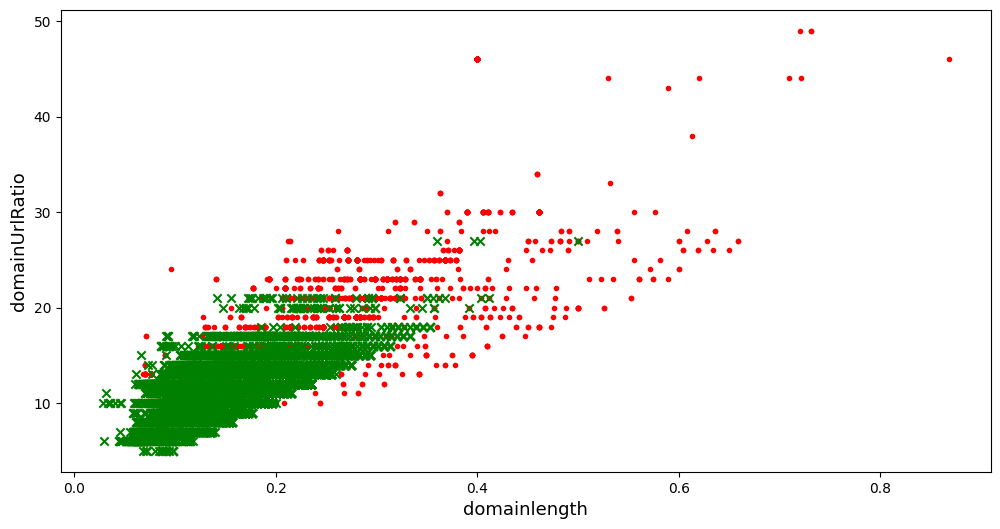

In [11]:
# Representacion grafica de dos caracteristicas.
plt.figure(figsize = (12,6))
plt.scatter(
    df["domainUrlRatio"][df["URL_Type_obf_Type"] == "malware"],
    df["domainlength"][df["URL_Type_obf_Type"] == "malware"],
    c = "r", marker = ".")

plt.scatter(
    df["domainUrlRatio"][df["URL_Type_obf_Type"] == "benign"],
    df["domainlength"][df["URL_Type_obf_Type"] == "benign"],
    c = "g", marker = "x")

plt.ylabel("domainUrlRatio", fontsize = 13)
plt.xlabel("domainlength", fontsize = 13)
plt.show()

## 3.- Division de los Datos

In [12]:
train_set, val_set, test_set = train_val_test_split(df)

In [13]:
X_train = train_set.drop("URL_Type_obf_Type", axis = 1)
y_train = train_set["URL_Type_obf_Type"].copy()

X_val = val_set.drop("URL_Type_obf_Type", axis = 1)
y_val = val_set["URL_Type_obf_Type"].copy()

X_test = test_set.drop("URL_Type_obf_Type", axis = 1)
y_test = test_set["URL_Type_obf_Type"].copy()

## 4.- Preparacion del DataSet

In [14]:
# Eliminar los atributos que contengan valores infinitos
X_train = X_train.drop("argPathRatio", axis = 1)
X_val = X_val.drop("argPathRatio", axis = 1)
X_test = X_test.drop("argPathRatio", axis = 1)

In [15]:
# Rellenar los valores nulos con la mediana
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [16]:
X_train_prep = imputer.fit_transform(X_train)
X_val_prep = imputer.fit_transform(X_val)
X_test_prep = imputer.fit_transform(X_test)

In [17]:
# Transformar el DataFrame de Pandas
X_train_prep = pd.DataFrame(X_train_prep, columns = X_train.columns, index = X_train.index)
X_val_prep = pd.DataFrame(X_val_prep, columns = X_val.columns, index = X_val.index)
X_test_prep = pd.DataFrame(X_test_prep, columns = X_test.columns, index = X_test.index)

In [18]:
X_train_prep.head(10)

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath
5559,0.0,2.0,9.0,7.000000,11.0,2.888889,2.0,8.0,1.0,0.0,...,7.0,0.0,0.0,-1.0,0.707031,0.897617,0.733490,0.775756,0.000000,-1.000000
2835,0.0,2.0,18.0,4.000000,6.0,3.888889,2.0,18.0,7.0,1.0,...,1.0,1.0,0.0,-1.0,0.683218,0.929897,0.898227,0.677033,1.000000,-1.000000
4700,0.0,2.0,13.0,6.000000,10.0,5.615385,2.0,30.0,19.0,0.0,...,-1.0,-1.0,-1.0,-1.0,0.642720,0.818007,-1.000000,-1.000000,-1.000000,-1.000000
2445,11.0,2.0,5.0,7.000000,11.0,4.000000,2.0,7.0,4.0,0.0,...,-1.0,4.0,0.0,3.0,0.830571,0.850608,0.758039,0.878064,0.000000,0.850928
2233,0.0,2.0,13.0,4.000000,5.0,3.461539,2.0,12.0,4.0,0.0,...,4.0,1.0,0.0,-1.0,0.718181,0.929897,0.820507,0.724918,1.000000,-1.000000
3050,0.0,2.0,4.0,4.500000,6.0,10.000000,2.0,11.0,6.0,4.0,...,2.0,0.0,0.0,-1.0,0.767676,0.856864,0.713552,0.738685,0.000000,-1.000000
10065,0.0,3.0,6.0,4.333334,7.0,9.166667,3.0,9.0,11.0,7.0,...,2.0,3.0,2.0,-1.0,0.757024,0.850608,0.713727,0.785150,0.783085,-1.000000
400,0.0,2.0,19.0,5.500000,8.0,4.578947,2.0,31.0,19.0,1.0,...,-1.0,-1.0,-1.0,-1.0,0.645024,0.953510,-1.000000,-1.000000,-1.000000,-1.000000
7614,0.0,3.0,20.0,4.333334,8.0,4.450000,3.0,31.0,19.0,0.0,...,2.0,1.0,0.0,-1.0,0.625094,0.897617,0.776021,0.660578,1.000000,-1.000000
10500,0.0,3.0,4.0,4.333334,7.0,13.500000,3.0,11.0,10.0,7.0,...,-1.0,3.0,2.0,-1.0,0.783506,0.850608,0.758039,0.801578,0.809341,-1.000000


In [19]:
# Comprobar si existe valores nulos en el DataSet de entreamiento.
is_null = X_train_prep.isna().any()
is_null[is_null]

Series([], dtype: bool)

## 5.- SVM: Kernel Lineal

### 5.1 DataSet Reducido

###### Entrenamiento del algoritmo de un DataSet Reducido

In [20]:
# Reducir el DataSet para representarlo graficamente
X_train_reduced = X_train_prep[["domainUrlRatio", "domainlength"].copy()]
X_val_reduced = X_val_prep[["domainUrlRatio", "domainlength"].copy()]

In [21]:
X_train_reduced

,domainUrlRatio,domainlength
5559,0.267857,15.0
2835,0.087379,9.0
4700,0.123810,13.0
2445,0.272727,15.0
2233,0.123288,9.0
...,...,...
5191,0.116667,14.0
13418,0.196970,13.0
5390,0.157895,9.0
860,0.072917,7.0


In [22]:
from sklearn.svm import SVC

# SVM Large Margin Classification

svm_clf = SVC(kernel = "linear", C = 50)
svm_clf.fit(X_train_reduced, y_train)

SVC(C=50, kernel='linear')

###### Representacion del limite de decision

In [23]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] *x0 -b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s = 180, facecolors = '#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth = 2)
    plt.plot(x0, gutter_up, "k--", linewidth = 2)
    plt.plot(x0, gutter_down, "k--", linewidth = 2)

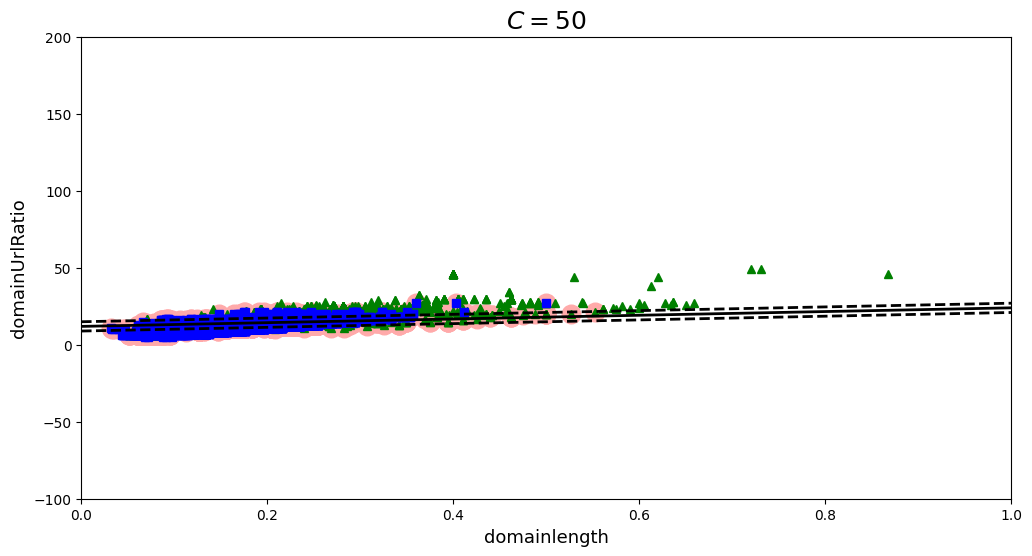

In [24]:
# Representacion grafica de dos caracteristicas.
plt.figure(figsize = (12,6))
plt.plot(
    X_train_reduced.values[:, 0][y_train == 'malware'],
    X_train_reduced.values[:, 1][y_train == 'malware'], "g^")
plt.plot(
    X_train_reduced.values[:, 0][y_train == 'benign'],
    X_train_reduced.values[:, 1][y_train == 'benign'], "bs")

plot_svc_decision_boundary(svm_clf, 0, 1)

plt.title("$C = {}$".format(svm_clf.C), fontsize = 18)
plt.axis([0, 1, -100, 200])


plt.ylabel("domainUrlRatio", fontsize = 13)
plt.xlabel("domainlength", fontsize = 13)
plt.show()

##### Predecir un DataSet reducido

In [25]:
y_pred = svm_clf.predict(X_val_reduced)

In [26]:
print("F1 Score: ", f1_score(y_pred, y_val, pos_label = 'malware'))

F1 Score:  0.6327907899960302


Como se vera adelante, para determinados kernels es muy importante escalar el conjunto de datos. En este caso, para el kernel lineal, no es tan relevante, aunque es posible que proporcione mejores resultados.

In [27]:
svm_clf_sc = Pipeline([
    ("scaler", RobustScaler()),
    ("linear_svc", SVC(kernel= "linear", C=50))
])
svm_clf_sc.fit(X_train_reduced, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('linear_svc', SVC(C=50, kernel='linear'))])

In [28]:
y_pred = svm_clf_sc.predict(X_val_reduced)

In [29]:
print("F1 Score: ", f1_score(y_pred, y_val, pos_label = 'malware'))

F1 Score:  0.6274038461538461


## 5.2 DataSet Completo

In [ ]:
# Entrenamiento con todo el DataSet
from sklearn.svm import SVC


svm_clf = SVC(kernel = "linear", C=1)
svm_clf.fit(X_train_prep, y_train)

In [ ]:
y_pred = svm_clf.predict(X_val_prep)
print("F1 Score: ", f1_score(y_pred, y_val, pos_label = 'malware'))

## 6.- SVM: Kernel (I)

### Polynomial Kernel (I)

##### Entrenamiento del algoritmo de un Dataset Reducido

In [ ]:
# Para representar el limite de decision, se tiene que pasar la variable objetivo a numerica

y_train_num = y_train.factorize()[0]
y_val_num = y_val.factorize()[0]

In [ ]:
from sklearn.datasets import make_moons
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C = 20, loss = "hinge", random_state = 42, max_iter = 100000))
])
polynomial_svm_clf.fit(X_train_reduced, y_train_num)

#### Representacion del limite de decision

In [ ]:
def plot_dataset(X, y):
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g.")
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "b.")

In [ ]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)

    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]

    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)

    plt.contourf(x0, x1, y_pred, cmap = plt.cm.brg, alpha = 0.1)


fig, axes = plt.subplots(ncols = 2, figsize = (15, 5), sharey = True)
plt.sca(axes[0])
plot_dataset(X_train_reduced.values, y_train_num)
plot_predictions(polynomial_svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize = 11)
plt.ylabel("domainlength", fontsize = 11)
plt.sca(axes[1])
plot_predictions(polynomial_svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize = 11)
plt.ylabel("domainlength", fontsize = 11)
plt.show()

#### Prediccion del DataSet reducido

In [ ]:
y_pred = polynomial_svm_clf.predict(X_val_reduced)

In [ ]:
print("F1 Score: ", f1_score(y_pred, y_val_num))

## 6.2 Polynomial Kernel (II)

Existe una forma mas sencilla de entrenar un algoritmo SVM que utilice polynomial kernel, utilizando el parametro **kernel** de la propia funcion implememtada en sklearn.

#### Entrenamiento del algoritmo  con un DataSet reducido

In [ ]:
svm_clf = SVC(kernel="poly", degree = 3, coef0 = 10, C = 20)
svm_clf.fit(X_train_reduced, y_train_num)

#### Representacion del limite de decision

In [ ]:
fig, axes = plt.subplots(ncols = 2, figsize = (15, 5), sharey = True)
plt.sca(axes[0])
plot_dataset(X_train_reduced.values, y_train_num)
plot_predictions(svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize = 11)
plt.ylabel("domainlength", fontsize = 11)
plt.sca(axes[1])
plot_predictions(svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize = 11)
plt.ylabel("domainlength", fontsize = 11)
plt.show()

#### Prediccion con el DataSet reducido

In [ ]:
y_pred = polynomial_svm_clf.predict(X_val_reduced)

In [ ]:
print("f1 score: ", f1_score(y_pred, y_val_num))

#### Prediccion con un DataSet completo

In [ ]:
rbf_kernel_svm_clf = Pipeline([
    ("scaler", RobustScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=0.05, C=1000))
])
rbf_kernel_svm_clf.fit(X_train_prep, y_train_num)

In [ ]:
y_pred = rbf_kernel_svm_clf.predict(X_val_prep)
print("f1 score: ", f1_score(y_pred, y_val_num))